Simulation script to evaluate how well we can recover feature representation from Gaussian process search.   
Author: Allen Ross

## Setup

In [1]:
# Libraries
import gpflow
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from gpflow.utilities import print_summary
from helper_functions import *
import os
import time
import pickle

# Options
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Functions
def sim_data(rate=12, num_units=30, fixed_num=False,
             include_output=False, kern_out=None,
             eps=0, set_seed=True):
    # Set random seed
    if set_seed:
        np.random.seed(9102)

    # Assign treatment group to each unit
    # treat_group = np.repeat([0,1], num_units/2)
    treat_group = np.random.binomial(n=1, p=0.5, size=num_units)

    # Sample number of observations for each unit
    if fixed_num:
        num_obs = np.repeat(rate, num_units)
    else:
        num_obs = np.random.poisson(lam=rate, size=num_units)

    # Sample from uniform distribution for observation times
    x = np.concatenate(
        [np.sort(np.round(np.random.uniform(low=0, high=12, size=i), 1)) for i in num_obs],
        axis=0
    )

    # Put unit ID and observation time together
    df = np.array([np.repeat(np.arange(num_units), num_obs),
                   np.repeat(treat_group, num_obs),
                   x]).T

    df = pd.DataFrame(
        df,
        columns=['id', 'treat', 'time']
    )

    # Standardize continuous variable
    # df.time = (df.time - df.time.mean()) / df.time.std()

    if include_output and kern_out is not None:

        for k in kern_out.keys():
            # Simulate output
            f_ = np.random.multivariate_normal(
                mean=np.zeros_like(df.iloc[:, 0]).flatten(),
                cov=kern_out[k]['model'](df) + 1e-6 * np.eye(df.shape[0]),
                size=1
            )[0]

            # Add noise
            df[k] = f_ + np.random.normal(loc=0, scale=eps, size=len(f_))

    return df

def run_simulation(rates, epsilons, units, iters, kernel_list):

    sim_out = pd.DataFrame()
    np.random.seed(9102)

    # Run loop for each iteration of rate and epsilon
    for r in rates:
        for u in units:
            for eps in epsilons:
                #print(f"Starting rate {r} with epsilon {eps}")
                for i in range(iters):
                    if i % 25 == 0:
                        print(f"Working on iteration {i} of rate {r} with {u} units and epsilon {eps}")

                    # Build temporary simulated data
                    temp_df = sim_data(
                        rate=r,
                        num_units=u,
                        include_output=True,
                        kern_out=kernel_dictionary,
                        set_seed=False,
                        eps=eps
                    )

                    # Run kernel search process
                    search_out = Parallel(n_jobs=4)(
                        delayed(full_kernel_search)(
                            X=temp_df[['id', 'treat', 'time']],
                            Y=temp_df.drop(columns=['id', 'treat', 'time']).iloc[:, i],
                            kern_list=kernel_list,
                            cat_vars=[0, 1],
                            max_depth=5,
                            early_stopping=True,
                            prune=True,
                            keep_all=False,
                            keep_only_best=True,
                            lik='gaussian',
                            random_seed=9102
                        )
                        for i in range(4)
                    )

                    # Save resulting kernels and information
                    cur_out = pd.DataFrame({
                        'rate': 4*[r],
                        'eps': 4*[eps],
                        'units': 4*[u],
                        'iter': 4*[i],
                        'output': ['y1', 'y2', 'y3', 'y4'],
                        'kernel': [x['best_model'] for x in search_out],
                        'model': [x['models'][x['best_model']] for x in search_out]
                    })

                    sim_out = sim_out.append(cur_out)
                print(f"Finished rate {r} with {u} units and epsilon {eps}")

    return sim_out.reset_index(drop=True)

## Kernel specifications

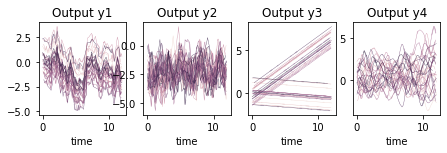

In [3]:
# First kernel is just a simple time varying covariance structure + unit offset
k1 = (gpflow.kernels.Matern12(variance=1.0,
                              lengthscales=1.0,
                              active_dims=[2]) +
      Categorical(variance=2.0,
                  active_dims=[0]))

# Second kernel is time varying unit specific effect + periodic overall effect
k2 = (gpflow.kernels.Matern12(variance=1.,
                              lengthscales=0.5,
                              active_dims=[2]) *
      Categorical(active_dims=[0]) +
      gpflow.kernels.Periodic(
          base_kernel=gpflow.kernels.SquaredExponential(
              variance=2., active_dims=[2]),
          period=3.0))

# Third kernel is random unit specific effect + treatment effect
k3 = (Categorical(active_dims=[0], variance=0.5) +
      Categorical(active_dims=[1]) *
      gpflow.kernels.Linear(variance=0.1,
                            active_dims=[2]))

# Fourth kernel is nonlinear random treatment effect over time +
# nonlinear individual effect over time
k4 = (Categorical(active_dims=[0], variance=0.5) +
      Categorical(active_dims=[1], variance=0.001) *
      gpflow.kernels.Polynomial(degree=2,
                                offset=3.,
                                variance=1.,
                                active_dims=[2]) +
      Categorical(active_dims=[0]) *
      gpflow.kernels.SquaredExponential(variance=1.,
                                        lengthscales=0.5,
                                        active_dims=[2]))

# Kernel dictionary
kernel_dictionary = {
    'y1': {'model': k1},
    'y2': {'model': k2},
    'y3': {'model': k3},
    'y4': {'model': k4}
}

# Sample from kernels to inspect potential output
samp_df = sim_data(rate=100,
                   num_units=30,
                   fixed_num=True,
                   include_output=True,
                   kern_out=kernel_dictionary,
                   set_seed=True)

# Plot resulting output
f, axs = plt.subplots(1, len(kernel_dictionary), figsize=(7.2, 1.7))
for i, k in enumerate(kernel_dictionary.keys()):
    p = sns.lineplot(data=samp_df,
                     x='time',
                     y=k,
                     hue='id',
                     legend=False,
                     alpha=0.9,
                     linewidth=0.35,
                     ax=axs[i])
    p.set_title(f'Output {k}')
    #if i != 0:
    p.set_ylabel('')
    p.plot()

## Simulation

In [ ]:
# Set options
rates = [5, 20] #[5, 10, 20] #[2, 4, 12]
units = [10, 100] #[10, 50, 100]
epsilons = [0.1, 10] #[0.1, 1, 10]
iters = 50 #100
kernel_list = [
    gpflow.kernels.SquaredExponential(),
    gpflow.kernels.Matern12(),
    gpflow.kernels.Linear(),
    #gpflow.kernels.Polynomial(),
    #gpflow.kernels.ArcCosine(),
    gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())
]

# Run simulation
start_time = time.time()
sim_results = run_simulation(rates, epsilons, units, iters, kernel_list)
end_time = time.time()
print("----%.2f seconds----"%(end_time - start_time))

# Save output
f = open("sim_results.pkl", "wb")
pickle.dump(sim_results, f)
f.close()

Working on iteration 0 of rate 5 with 10 units and epsilon 0.1
Working on iteration 25 of rate 5 with 10 units and epsilon 0.1
Finished rate 5 with 10 units and epsilon 0.1
Working on iteration 0 of rate 5 with 10 units and epsilon 10
Working on iteration 25 of rate 5 with 10 units and epsilon 10
Finished rate 5 with 10 units and epsilon 10
Working on iteration 0 of rate 5 with 100 units and epsilon 0.1
Working on iteration 25 of rate 5 with 100 units and epsilon 0.1
Finished rate 5 with 100 units and epsilon 0.1
Working on iteration 0 of rate 5 with 100 units and epsilon 10
Working on iteration 25 of rate 5 with 100 units and epsilon 10
Finished rate 5 with 100 units and epsilon 10
Working on iteration 0 of rate 20 with 10 units and epsilon 0.1
Working on iteration 25 of rate 20 with 10 units and epsilon 0.1
Finished rate 20 with 10 units and epsilon 0.1
Working on iteration 0 of rate 20 with 10 units and epsilon 10
Working on iteration 25 of rate 20 with 10 units and epsilon 10
Finis

In [4]:
# Load if needed
sim_results = pickle.load(open( "sim_results.pkl", "rb" ))

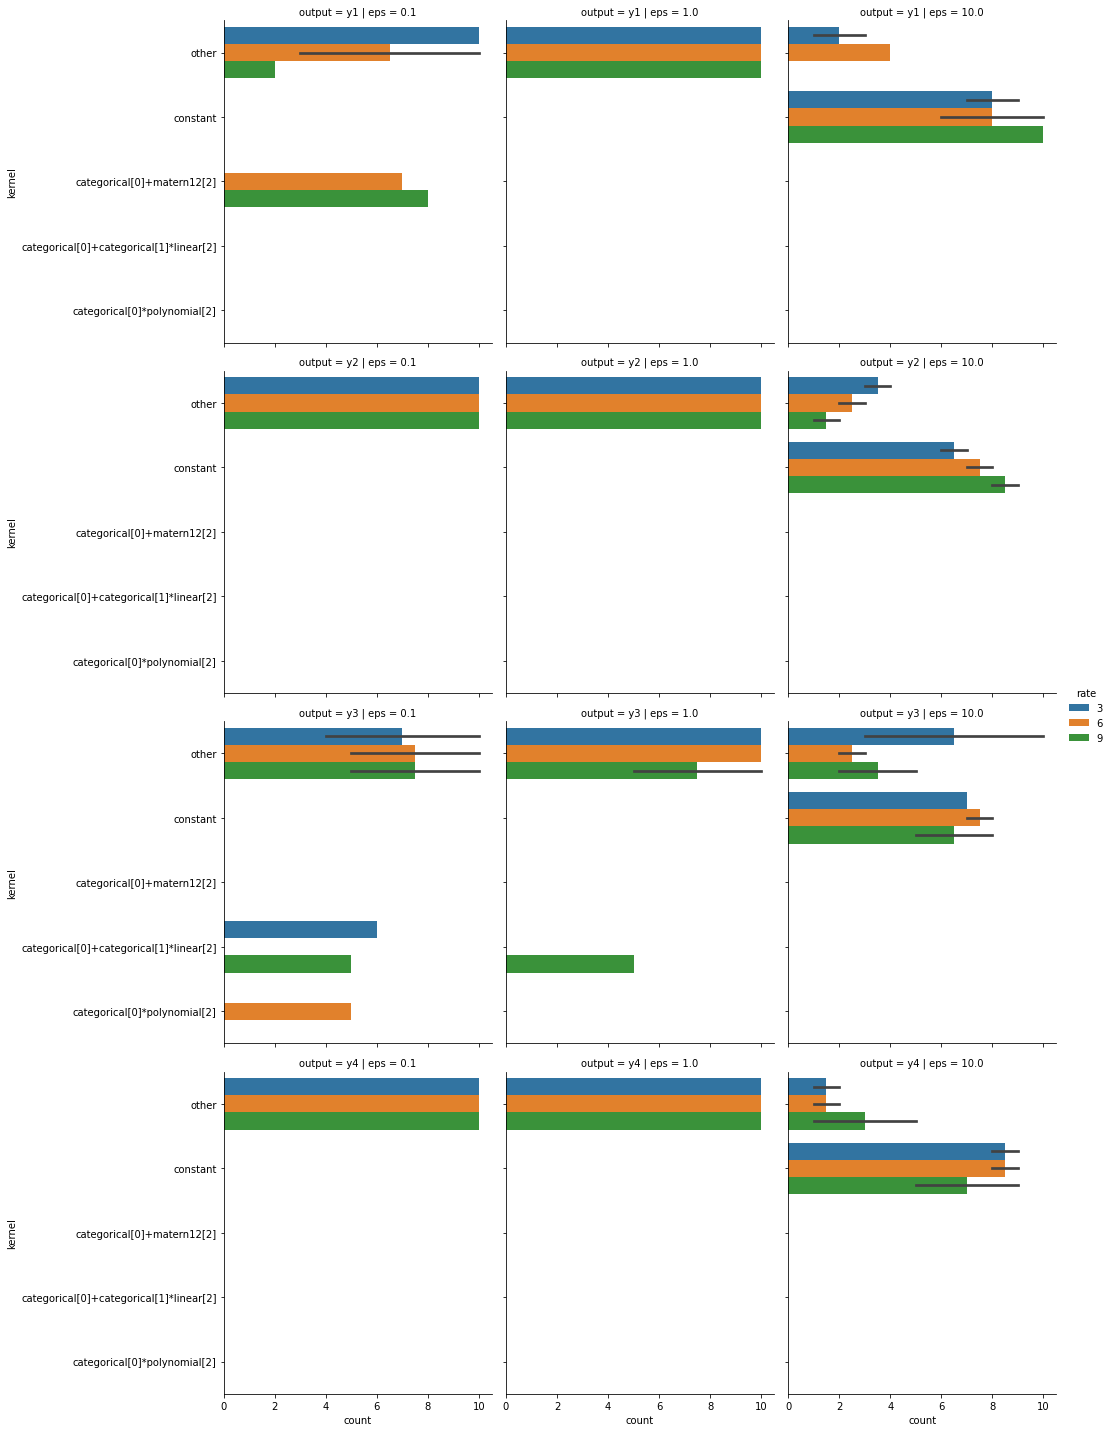

In [15]:
# Reformat and visualize output
true_kernels = pd.DataFrame({
    'output': ['y1', 'y2', 'y3', 'y4'],
    'kernel': [['matern12[2]', 'categorical[0]'],
        ['categorical[0]*matern12[2]', 'periodic[2]'],
        ['categorical[0]', 'categorical[1]*linear[2]'],
        ['categorical[1]*polynomial[2]', 'categorical[0]*squared_exponential[2]']]
})

# Split final kernels, expand to each row, and then count number of occurrences
sim_results['kernel_parts'] = [x.split('+') for x in sim_results.kernel]
sim_results_long = sim_results.drop(columns=['kernel', 'model']).explode('kernel_parts')
# sim_results_long_agg = sim_results_long. \
    # groupby(['rate', 'eps', 'output', 'kernel_parts']). \

sim_results_long_agg = sim_results. \
    groupby(['rate', 'eps', 'output', 'units', 'kernel']). \
    size(). \
    reset_index(name='count'). \
    sort_values('count', ascending=False)
# Bucket unlikely results together
# sim_results_long_agg. \
#     loc[(sim_results_long_agg['count'] < 5).values, 'kernel_parts'] = 'other'
sim_results_long_agg. \
    loc[(sim_results_long_agg['count'] < 5).values, 'kernel'] = 'other'
    
# groupby(['rate', 'eps', 'output', 'kernel_parts']). \
sim_results_long_agg = sim_results_long_agg. \
    groupby(['rate', 'eps', 'output', 'units', 'kernel']). \
    sum(). \
    reset_index(). \
    sort_values('count', ascending=False)

sns.catplot(
    data=sim_results_long_agg,
    x='count',
    # y='kernel_parts',
    y='kernel',
    col='eps', #'output',
    hue='rate',
    row='output', #'eps',
    kind='bar',
    row_order=['y1', 'y2', 'y3', 'y4'],
    # sharey=False
);